# ORF recognition by LSTM
LSTM was incapable of ORF recognition on 1000 bp sequences. Try smaller.


In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-19 10:17:30 UTC'

In [2]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=125            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM,GRU,SimpleRNN
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen
def get_the_facts(seqs):
    rd = RNA_describer()
    facts = rd.get_three_lengths(seqs)
    facts_ary = np.asarray(facts) # 5000 rows, 3 columns 
    print("Facts array:",type(facts_ary))
    print("Facts array:",facts_ary.shape)
    # Get the mean of each column
    mean_5utr, mean_orf, mean_3utr = np.mean(facts_ary,axis=0)
    std_5utr, std_orf, std_3utr = np.std(facts_ary,axis=0)
    print("mean 5' UTR length:",int(mean_5utr),"+/-",int(std_5utr))
    print("mean    ORF length:",int(mean_orf), "+/-",int(std_orf))
    print("mean 3' UTR length:",int(mean_3utr),"+/-",int(std_3utr))

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
get_the_facts(pc_train)
print("Train on",len(nc_train),"NC seqs")
get_the_facts(nc_train)

Train on 20000 PC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 28 +/- 9
mean    ORF length: 64 +/- 12
mean 3' UTR length: 31 +/- 7
Train on 20000 NC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 48 +/- 24
mean    ORF length: 26 +/- 28
mean 3' UTR length: 50 +/- 24


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(GRU(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(GRU(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (125, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 125, 32)           3648      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 28s 11ms/step - loss: 0.6935 - accuracy: 0.5081 - val_loss: 0.6939 - val_accuracy: 0.5001


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4931 - val_loss: 0.6933 - val_accuracy: 0.5001
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5011


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5036


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.4973 - val_loss: 0.6933 - val_accuracy: 0.4999
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6929 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5094


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4936 - val_loss: 0.6933 - val_accuracy: 0.5001
Epoch 9/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5001
Epoch 10/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 11/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.5013
Epoch 12/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6939 - val_accuracy: 0.5010
Epoch 13/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.5020
Epoch 14/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6592 - accuracy: 0.6074 - val_loss: 0.6194 - val_accuracy: 0.6660


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5068 - accuracy: 0.7581 - val_loss: 0.3668 - val_accuracy: 0.8495


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3879 - accuracy: 0.8318 - val_loss: 0.3573 - val_accuracy: 0.8494
Epoch 24/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3750 - accuracy: 0.8389 - val_loss: 0.3661 - val_accuracy: 0.8471
Epoch 25/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3655 - accuracy: 0.8386 - val_loss: 0.3550 - val_accuracy: 0.8461
Epoch 26/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3446 - accuracy: 0.8477 - val_loss: 0.3297 - val_accuracy: 0.8590


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3279 - accuracy: 0.8594 - val_loss: 0.2791 - val_accuracy: 0.8907


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2922 - accuracy: 0.8828 - val_loss: 0.3280 - val_accuracy: 0.8777
Epoch 29/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2748 - accuracy: 0.8970 - val_loss: 0.2698 - val_accuracy: 0.9020


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2721 - accuracy: 0.9000 - val_loss: 0.2385 - val_accuracy: 0.9133


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2561 - accuracy: 0.9036 - val_loss: 0.2429 - val_accuracy: 0.9135


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2467 - accuracy: 0.9063 - val_loss: 0.2180 - val_accuracy: 0.9225


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2553 - accuracy: 0.9049 - val_loss: 0.3263 - val_accuracy: 0.8844
Epoch 34/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2378 - accuracy: 0.9124 - val_loss: 0.2542 - val_accuracy: 0.9018
Epoch 35/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2343 - accuracy: 0.9135 - val_loss: 0.2171 - val_accuracy: 0.9225
Epoch 36/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2186 - accuracy: 0.9218 - val_loss: 0.2016 - val_accuracy: 0.9276


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2171 - accuracy: 0.9205 - val_loss: 0.2426 - val_accuracy: 0.9187
Epoch 38/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2146 - accuracy: 0.9237 - val_loss: 0.2026 - val_accuracy: 0.9314


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2126 - accuracy: 0.9235 - val_loss: 0.1933 - val_accuracy: 0.9333


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2005 - accuracy: 0.9289 - val_loss: 0.2015 - val_accuracy: 0.9340


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2029 - accuracy: 0.9284 - val_loss: 0.1898 - val_accuracy: 0.9333
Epoch 42/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2039 - accuracy: 0.9288 - val_loss: 0.1871 - val_accuracy: 0.9364


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1961 - accuracy: 0.9326 - val_loss: 0.1796 - val_accuracy: 0.9381


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1967 - accuracy: 0.9306 - val_loss: 0.2000 - val_accuracy: 0.9306
Epoch 45/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2023 - accuracy: 0.9280 - val_loss: 0.1813 - val_accuracy: 0.9358
Epoch 46/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1999 - accuracy: 0.9298 - val_loss: 0.1913 - val_accuracy: 0.9319
Epoch 47/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1870 - accuracy: 0.9349 - val_loss: 0.1895 - val_accuracy: 0.9345
Epoch 48/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1850 - accuracy: 0.9354 - val_loss: 0.2010 - val_accuracy: 0.9335
Epoch 49/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1792 - accuracy: 0.9385 - val_loss: 0.1669 - val_accuracy: 0.9449


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1835 - accuracy: 0.9361 - val_loss: 0.1641 - val_accuracy: 0.9446
Fold 1, 50 epochs, 655 sec


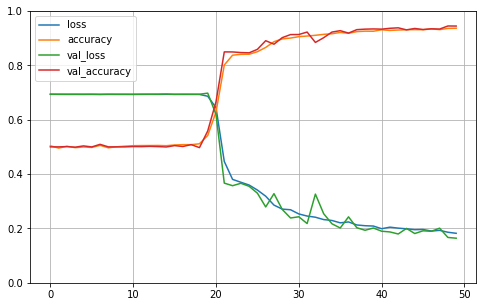

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 12s 11ms/step - loss: 0.6997 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.4991
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4992 - val_loss: 0.6948 - val_accuracy: 0.4995
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5015 - val_loss: 0.6949 - val_accuracy: 0.4995
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6941 - accuracy: 0.4965 - val_loss: 0.6933 - val_accuracy: 0.5005
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4956 - val_loss: 0.6944 - val_accuracy: 0.4995
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.5006 - val_loss: 0.6937 - val_accuracy: 0.4995
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

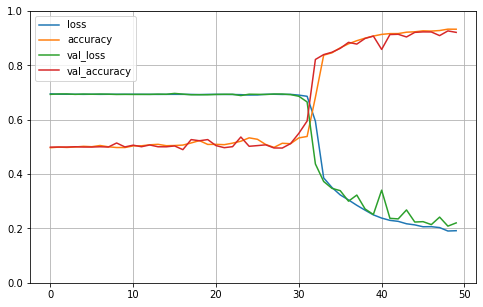

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 12s 11ms/step - loss: 0.6952 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.4980
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4940
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6934 - accuracy: 0.5023 - val_loss: 0.6935 - val_accuracy: 0.4924
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.5004 - val_loss: 0.6943 - val_accuracy: 0.4978
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6943 - val_accuracy: 0.4980
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4971
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

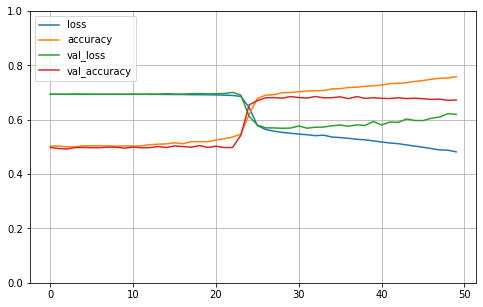

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 12s 11ms/step - loss: 0.6962 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5050
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5022 - val_loss: 0.6936 - val_accuracy: 0.4956
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6936 - val_accuracy: 0.4945
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6950 - val_accuracy: 0.4960
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.4960
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

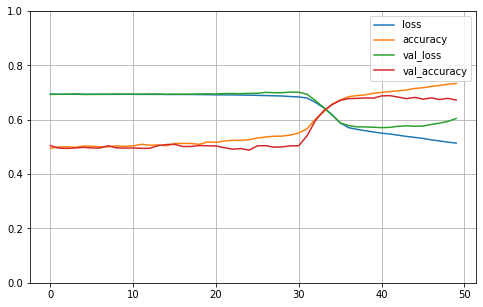

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.7041 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6943 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5048
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.4977 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.694

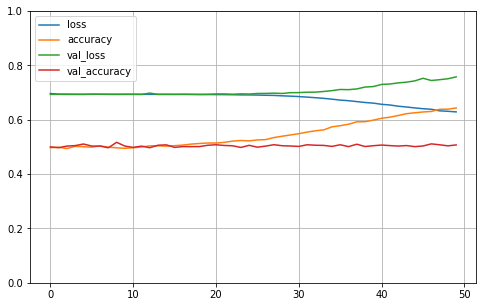

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 94.55%


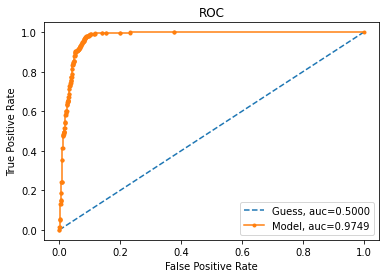

AUC: 0.97%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-19 11:02:28 UTC'